In [7]:
import pandas as pd
import numpy as np
import pyhomogeneity as hg
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import skew, t
%config Completer.use_jedi = False #for auto complete code 

In [8]:
obs=pd.read_csv('../data/precp/pp.csv',sep=';')
obs['Fecha'] = pd.to_datetime(obs['Fecha'], dayfirst=True)

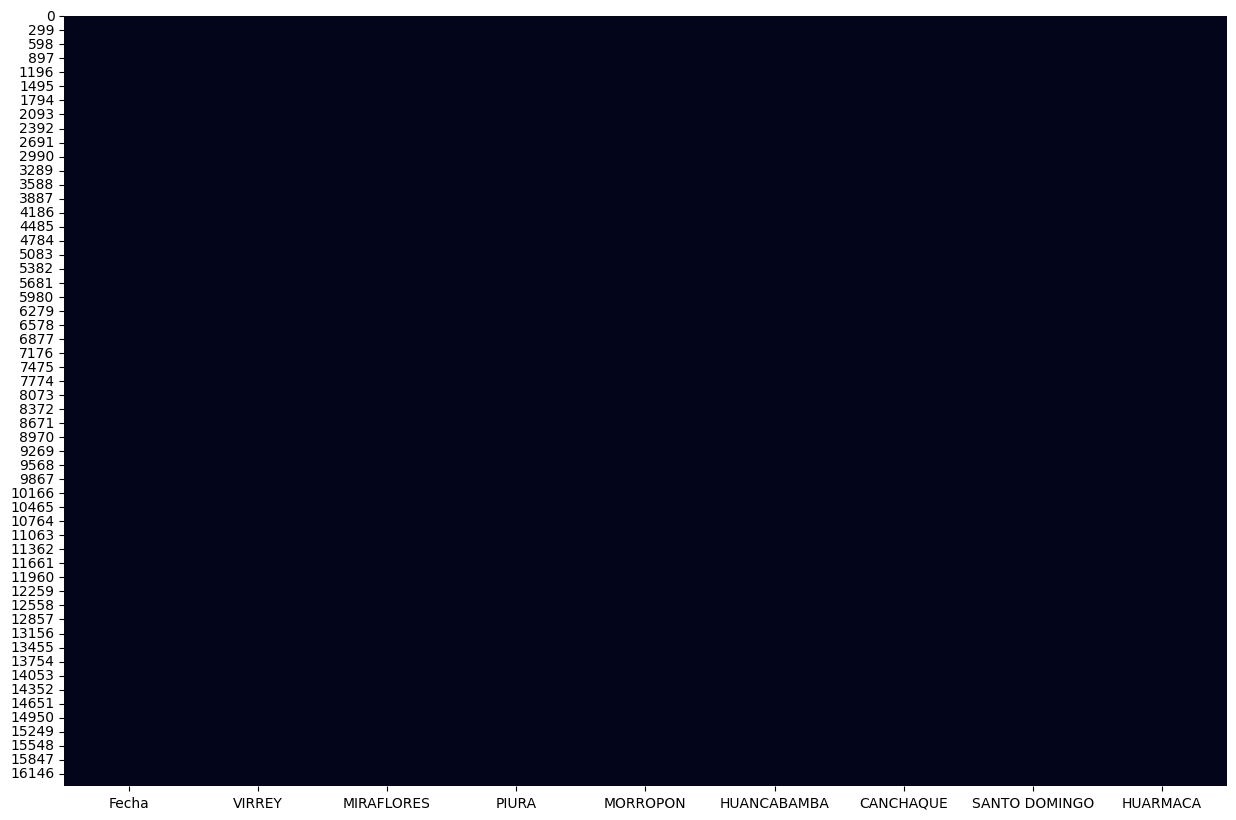

In [9]:
plt.figure(figsize=(15,10))
sns.heatmap(obs.isnull(), cbar=False)
plt.show()

# Remover años El Niño

In [12]:
def remove_years(df, years_to_remove):
    # Convert the first column to datetime if it is not already
    df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
    
    # Filter out the rows where the year of the date is in the years_to_remove list
    df_filtered = df[~df.iloc[:, 0].dt.year.isin(years_to_remove)]
    
    return df_filtered


# List of years to remove
years_to_remove = [1982,1983,1983,1998,2017]

# Remove the specified years
df_cleaned = remove_years(obs, years_to_remove)

# Display the result
df_cleaned.head(10)


,Fecha,VIRREY,MIRAFLORES,PIURA,MORROPON,HUANCABAMBA,CANCHAQUE,SANTO DOMINGO,HUARMACA
0,1972-01-01,0.0,0.00,0.0,0.0,6.70,6.8,0.0,3.70
1,1972-01-02,0.0,0.00,0.0,0.0,0.10,1.4,6.4,0.01
2,1972-01-03,0.0,0.40,0.0,0.0,2.60,14.0,18.4,4.10
3,1972-01-04,0.0,1.50,2.0,0.0,0.90,1.4,4.6,2.40
4,1972-01-05,0.0,0.00,0.0,0.0,0.01,1.9,5.6,0.01
5,1972-01-06,0.0,0.00,0.0,0.0,0.00,0.0,0.8,4.10
6,1972-01-07,0.0,0.00,0.0,0.0,2.90,0.5,0.9,0.00
7,1972-01-08,0.0,0.00,0.0,0.0,0.10,0.0,0.7,0.01
8,1972-01-09,0.0,0.00,0.0,0.0,0.40,0.1,2.6,3.10
9,1972-01-10,0.0,0.01,0.0,0.0,1.70,0.8,3.1,1.10


# Doble Masa

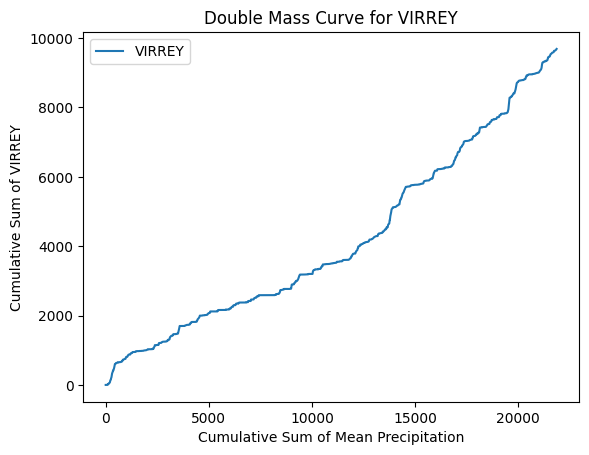

C:\Users\Usuario\AppData\Local\Temp\ipykernel_5080\1487194434.py:32: RuntimeWarning: invalid value encountered in divide
  derivative = np.diff(cumulative_sum) / np.diff(cumulative_mean)


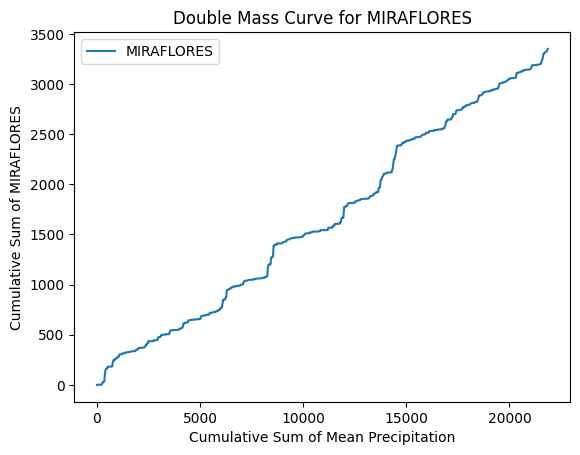

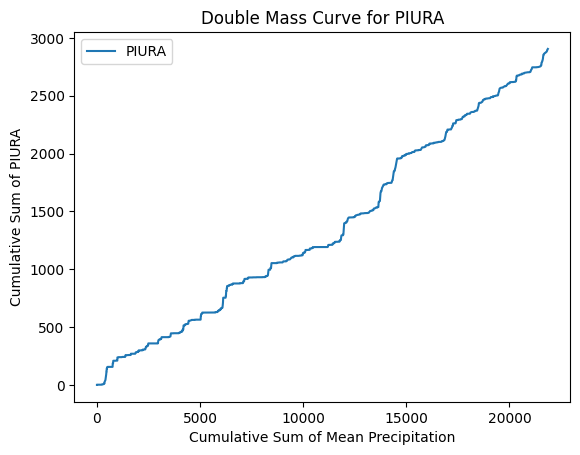

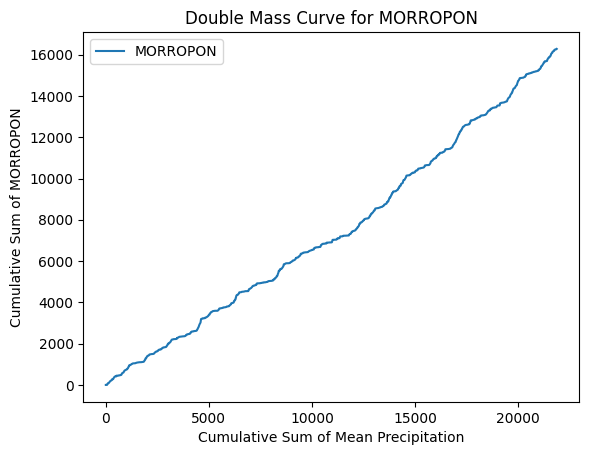

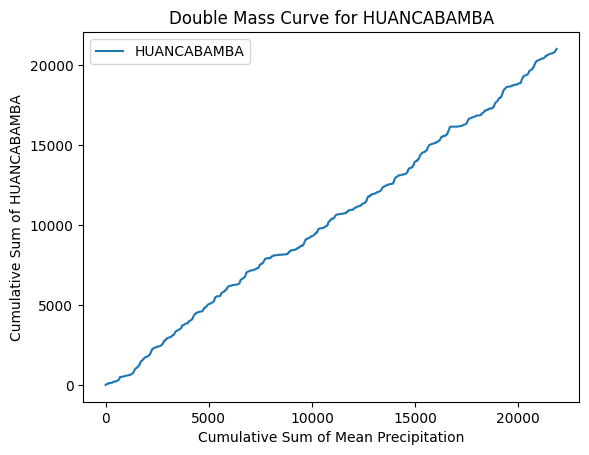

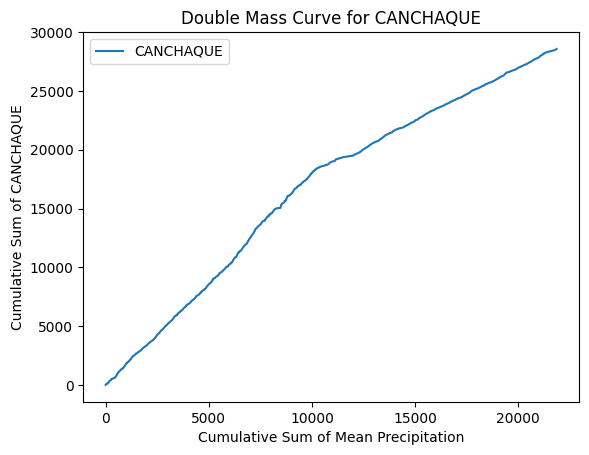

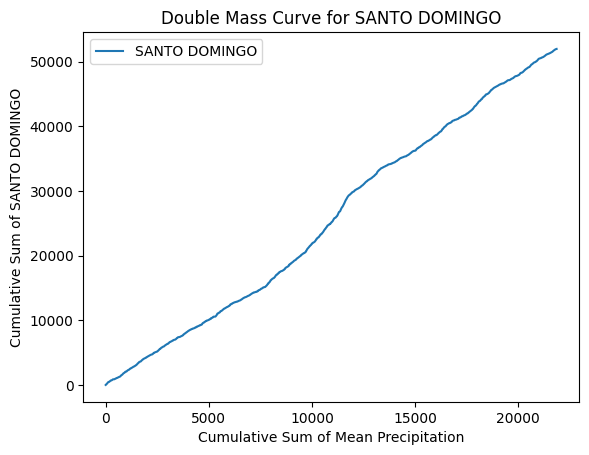

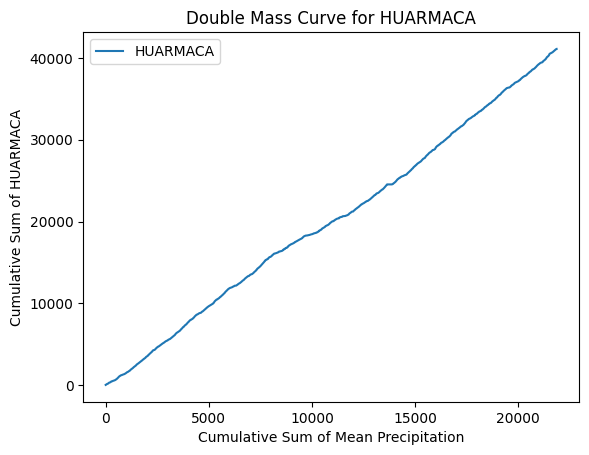

{'VIRREY': [], 'MIRAFLORES': [], 'PIURA': [], 'MORROPON': [], 'HUANCABAMBA': [], 'CANCHAQUE': [], 'SANTO DOMINGO': [], 'HUARMACA': []}


In [13]:
def identify_breaks_dmc(df):
    # Ensure the first column is in datetime format
    df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
    
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df_copy = df.copy()
    
    # Calculate the mean of all gauge stations and add it to the copy DataFrame
    df_copy['Mean'] = df_copy.iloc[:, 1:].mean(axis=1)
    
    # Initialize a dictionary to store results
    breaks_dict = {}
    
    # Calculate cumulative sum of the mean column
    cumulative_mean = df_copy['Mean'].cumsum()
    
    # Iterate over each gauge station, excluding the mean column
    for col in df_copy.columns[1:-1]:
        # Calculate the cumulative sums for the gauge station
        cumulative_sum = df_copy[col].cumsum()
        
        # Plot the double mass curve for visual inspection (optional)
        plt.figure()
        plt.plot(cumulative_mean, cumulative_sum, label=col)
        plt.xlabel('Cumulative Sum of Mean Precipitation')
        plt.ylabel(f'Cumulative Sum of {col}')
        plt.title(f'Double Mass Curve for {col}')
        plt.legend()
        plt.show()
        
        # Identify breaks in the slope using changes in the derivative
        derivative = np.diff(cumulative_sum) / np.diff(cumulative_mean)
        breaks = np.where(np.abs(np.diff(derivative)) > np.mean(np.abs(np.diff(derivative))) + 2 * np.std(np.abs(np.diff(derivative))))[0]
        
        # Store the indices of the breaks in the dictionary
        breaks_dict[col] = list(breaks + 1)  # +1 to account for the shift caused by np.diff
    
    return breaks_dict

# Example usage:
# Assuming df_cleaned is the filtered DataFrame from the previous step
breaks = identify_breaks_dmc(df_cleaned)

# Display the result
print(breaks)

In [14]:
df_cleaned.set_index('Fecha',inplace=True)

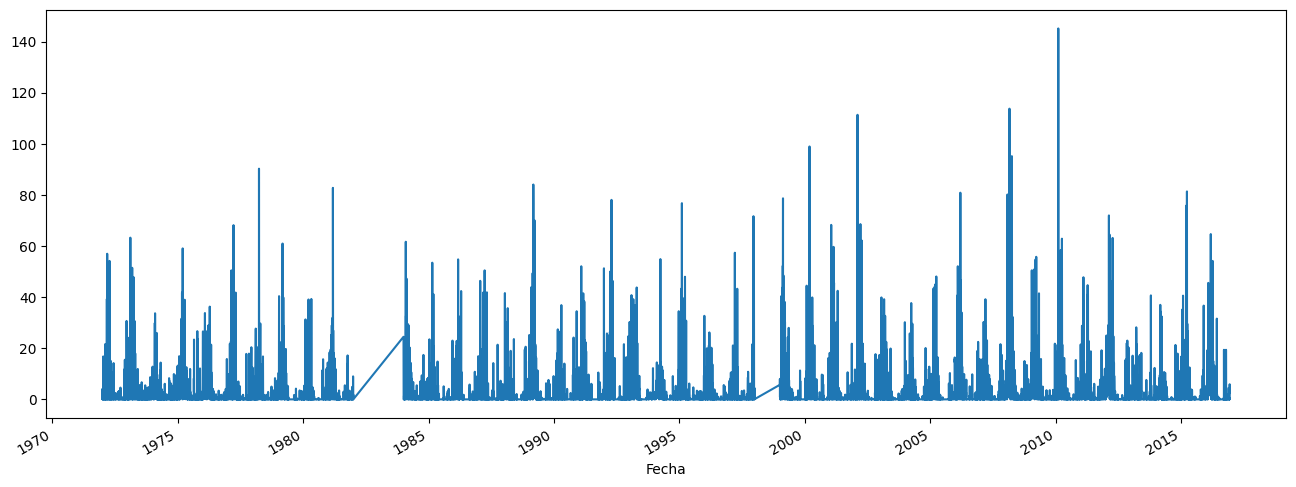

In [15]:
df_cleaned.HUARMACA.plot(figsize=(16,6));

In [35]:
df_monthly = df_cleaned.groupby(df_cleaned.index.to_period('Y')).sum()

In [34]:
def perform_tests_summary(df_cleaned):
    stations = df_cleaned.columns[1:]  # Exclude the date column
    summary_data = []

    for station in stations:
        pettitt_res = hg.pettitt_test(df_cleaned[[station]], alpha=0.01)
        snht_res = hg.snht_test(df_cleaned[[station]], sim=100000)
        buishand_res = hg.buishand_u_test(df_cleaned[[station]])

        summary_data.append({
            'Station': station,
            'Pettitt_CP': pettitt_res.cp,
            'Pettitt_Hypothesis': pettitt_res.h,
            'Pettitt_Mean_Pre': pettitt_res.avg.mu1,
            'Pettitt_Mean_Post': pettitt_res.avg.mu2,
            'SNHT_CP': snht_res.cp,
            'SNHT_Hypothesis': snht_res.h,
            'SNHT_Mean_Pre': snht_res.avg.mu1,
            'SNHT_Mean_Post': snht_res.avg.mu2,
            'Buishand_CP': buishand_res.cp,
            'Buishand_Hypothesis': buishand_res.h,
            'Buishand_Mean_Pre': buishand_res.avg.mu1,
            'Buishand_Mean_Post': buishand_res.avg.mu2
        })

    summary_df = pd.DataFrame(summary_data)
    return summary_df

# Assuming df_cleaned is already defined and contains your cleaned data
summary_table = perform_tests_summary(df_month)

# Display the summary table
print(summary_table)

         Station  Pettitt_CP  Pettitt_Hypothesis  Pettitt_Mean_Pre  \
0     MIRAFLORES          23               False         67.114087   
1          PIURA          23               False         51.816522   
2       MORROPON          18               False        280.531667   
3    HUANCABAMBA          19               False        435.691579   
4      CANCHAQUE          21                True        880.523524   
5  SANTO DOMINGO          17               False        890.011765   
6       HUARMACA          23               False        878.140087   

   Pettitt_Mean_Post  SNHT_CP  SNHT_Hypothesis  SNHT_Mean_Pre  SNHT_Mean_Post  \
0          95.062091        2            False     161.805000       75.654843   
1          90.132091       23            False      51.816522       90.132091   
2         467.830007       18            False     280.531667      467.830007   
3         554.350005       19            False     435.691579      554.350005   
4         480.186775       21     